# Projeto de Mineração de Dados

## Introdução & Proposta

O presente projeto-experimento tem por finalidade apresentar um classificador de sentimentos com base em comentários (análises) de filmes do IMDb em português. Este projeto realiza experimentos a partir de três modelos-algoritmos: Naive Bayes, Decision Tree e Support-Vector Machine. As seguintes técnicas de pré-processamento são utilizadas neste experimento: `Count Vectorizer` com e sem remoção de *stopwords*; `TF-IDF Vectorizer` com e sem remoção de *stopwords*; `Count Vectorizer` + `TF-IDF Vectorizer` com e sem remoção de *stopwords*; e experimentos com *Unigram*, *Bigram* e *Trigram*.

A acurácia dos modelos propostos é avaliada a partir da métrica **F1 Score**. Ao final, os experimentos são comparados a partir desta métrica.

## Obtenção da base de dados

A classe a seguir será usada para acompanhar o progresso do download. Em seguida, é feita a verificação se a base de dados está disponível: caso esteja disponível, nenhuma alteração é feita; caso contrário, os dados são baixados e descompactados.

In [1]:
import tqdm
from tqdm import tqdm

class DLProgress(tqdm):
  last_block = 0

  def hook(self, block_num=1, block_size=1, total_size=None):
    self.total = total_size
    self.update((block_num - self.last_block) * block_size)
    self.last_block = block_num

In [2]:
from urllib.request import urlretrieve
from os.path import isfile
import zipfile

path = "datasets/imdb-pt-br.zip"
url = "https://drive.google.com/uc?export=download&id=1Jz3H23oBy3yDf8ARQsflwRX-EFX7HKqM"

if not isfile(path):
  with DLProgress(unit="B", unit_scale=True, miniters=1, desc="IMDB") as pbar:
    urlretrieve(
      url,
      path,
      pbar.hook)

if not isfile("datasets/imdb-review-pt-br.csv"):     
  zip_ref = zipfile.ZipFile(path, "r")
  zip_ref.extractall("datasets")
  zip_ref.close()

In [3]:
!ls -all -h datasets/imdb-reviews-pt-br.csv

-rw-r--r-- 1 earaujoassis users 122M Aug 28 19:15 datasets/imdb-reviews-pt-br.csv


## Definições comuns aos modelos de análise

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def remove_stopwords_and_punctuation(docs):
    stop_words = set(stopwords.words("portuguese"))
    neo_docs = []

    for sentence in docs:
        cleanr = re.compile('<.*?>')
        sentence = re.sub(r'\d+', '', sentence)
        sentence = re.sub(cleanr, '', sentence)
        sentence = re.sub("'", '', sentence)
        sentence = re.sub(r'\W+', ' ', sentence)
        sentence = sentence.replace('_', '')
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        neo_docs.append(sentence)

    return neo_docs

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/earaujoassis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
df_master = pd.read_csv("datasets/imdb-reviews-pt-br.csv", encoding="utf-8", index_col=0)

In [9]:
list(df_master.head())

['text_en', 'text_pt', 'sentiment']

In [10]:
df_master[["text_pt", "sentiment"]]

,text_pt,sentiment
id,,
1,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
2,Este é um exemplo do motivo pelo qual a maiori...,neg
3,"Primeiro de tudo eu odeio esses raps imbecis, ...",neg
4,Nem mesmo os Beatles puderam escrever músicas ...,neg
5,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...
49456,"Como a média de votos era muito baixa, e o fat...",pos
49457,O enredo teve algumas reviravoltas infelizes e...,pos
49458,Estou espantado com a forma como este filme e ...,pos


In [11]:
# Shuffle the data frame and its content/rows/entries and
# remove entries with NaN at `text_pt` column
df_master = df_master[pd.notnull(df_master['text_pt'])]
df_master = df_master.sample(frac=1).reset_index(drop=True)
df_master[['text_pt', 'sentiment']]

,text_pt,sentiment
0,Dark Harvest é uma produção de orçamento muito...,neg
1,"""Ambos tropeçaram juntos neste mundo sem forma...",pos
2,Eu aluguei este filme porque parecia bem inter...,neg
3,A morte violenta de Fernando Ramos da Silva ap...,pos
4,"Eu tenho que dizer, eu amei Vanishing Point. E...",pos
...,...,...
49454,"Um humor infantil frenético, um tanto mesquinh...",neg
49455,"Absolutamente unwatchable, menor qualidade cin...",neg
49456,"Hmmm, não é um patch no original da Shaw Broth...",neg
49457,Eu assisti os primeiros 10 minutos deste show ...,neg


In [12]:
number_rows = df_master.shape[0]
traninng_threshold = int(0.40 * number_rows)

In [13]:
training_df = df_master[['text_pt', 'sentiment']].iloc[0:traninng_threshold]
testing_df = df_master[['text_pt', 'sentiment']].iloc[traninng_threshold + 1:-1]

In [14]:
training_df

,text_pt,sentiment
0,Dark Harvest é uma produção de orçamento muito...,neg
1,"""Ambos tropeçaram juntos neste mundo sem forma...",pos
2,Eu aluguei este filme porque parecia bem inter...,neg
3,A morte violenta de Fernando Ramos da Silva ap...,pos
4,"Eu tenho que dizer, eu amei Vanishing Point. E...",pos
...,...,...
19778,A Porta Dourada é a história de uma viagem fam...,pos
19779,"No final dos anos 40, a era da comédia maluca ...",pos
19780,As pessoas que estão falando mal desse filme s...,pos
19781,Lost guarda algo interessante para todos. Você...,pos


In [15]:
testing_df

,text_pt,sentiment
19784,Trabalho com câmeras - Por que o trabalho da c...,neg
19785,"Então, um dia, eu estava na locadora procurand...",neg
19786,Acabei de voltar do cinema de madrugada e foi ...,pos
19787,Um multi-milionário se casa com uma médica. El...,neg
19788,Filme sem sentido sobre como fazer um filme. N...,neg
...,...,...
49453,Este é um dos melhores filmes de terror que já...,pos
49454,"Um humor infantil frenético, um tanto mesquinh...",neg
49455,"Absolutamente unwatchable, menor qualidade cin...",neg
49456,"Hmmm, não é um patch no original da Shaw Broth...",neg


## Preparação, treinamento, predição & análise dos dados


### *DecisionTreeClassifier*

#### *DecisionTreeClassifier* + *CountVectorizer*

In [16]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [17]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [19]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [20]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [21]:
experiment_01 = f1_score(y_true, y_pred, average=None)
experiment_01

array([0.69950242, 0.69808134])

#### *DecisionTreeClassifier* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [22]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [23]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [24]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [25]:
testing_classes

array(['neg', 'neg', 'neg', ..., 'neg', 'pos', 'pos'], dtype=object)

In [26]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [27]:
experiment_01_sw = f1_score(y_true, y_pred, average=None)
experiment_01_sw

array([0.70363975, 0.70640325])

#### DecisionTreeClassifier + TfidfVectorizer

In [28]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [29]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [31]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'pos', 'neg'], dtype=object)

In [32]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [33]:
experiment_02 = f1_score(y_true, y_pred, average=None)
experiment_02

array([0.69301526, 0.69291179])

#### DecisionTreeClassifier + TfidfVectorizer &mdash; com remoção de *stopwords*

In [34]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [35]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [36]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [37]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'pos', 'neg'], dtype=object)

In [38]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [39]:
experiment_02_sw = f1_score(y_true, y_pred, average=None)
experiment_02_sw

array([0.69783184, 0.6944115 ])

#### *DecisionTreeClassifier* + (*CountVectorizer* + *TfidfVectorizer*)

In [40]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [41]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [42]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [43]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [44]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [45]:
experiment_03 = f1_score(y_true, y_pred, average=None)
experiment_03

array([0.69131811, 0.69090173])

#### *DecisionTreeClassifier* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [46]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [47]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [48]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [49]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'pos', 'neg'], dtype=object)

In [50]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [51]:
experiment_03_sw = f1_score(y_true, y_pred, average=None)
experiment_03_sw

array([0.70300222, 0.70091309])

#### *DecisionTreeClassifier* + Unigram

In [52]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [53]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [54]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [55]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'pos', 'neg', 'pos'], dtype=object)

In [56]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [57]:
experiment_04 = f1_score(y_true, y_pred, average=None)
experiment_04

array([0.70106581, 0.70345383])

#### *DecisionTreeClassifier* + Unigram &mdash; com remoção de *stopwords*

In [58]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [59]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [60]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [61]:
testing_classes

array(['neg', 'neg', 'neg', ..., 'neg', 'pos', 'pos'], dtype=object)

In [62]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [63]:
experiment_04_sw = f1_score(y_true, y_pred, average=None)
experiment_04_sw

array([0.70489473, 0.70750856])

#### *DecisionTreeClassifier* + Bigram

In [64]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [65]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [66]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [67]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype=object)

In [68]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [69]:
experiment_05 = f1_score(y_true, y_pred, average=None)
experiment_05

array([0.71439169, 0.71473798])

#### *DecisionTreeClassifier* + Bigram &mdash; com remoção de *stopwords*

In [70]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [71]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [72]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [73]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'pos', 'neg'], dtype=object)

In [74]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [75]:
experiment_05_sw = f1_score(y_true, y_pred, average=None)
experiment_05_sw

array([0.71702549, 0.71513102])

#### *DecisionTreeClassifier* + Trigram

In [76]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [77]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [78]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [79]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype=object)

In [80]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [81]:
experiment_06 = f1_score(y_true, y_pred, average=None)
experiment_06

array([0.71046163, 0.70997335])

#### *DecisionTreeClassifier* + Trigram &mdash; com remoção de *stopwords*

In [82]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [83]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [84]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [85]:
testing_classes

array(['pos', 'neg', 'pos', ..., 'neg', 'pos', 'pos'], dtype=object)

In [86]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [87]:
experiment_06_sw = f1_score(y_true, y_pred, average=None)
experiment_06_sw

array([0.71816467, 0.71797465])

### *MultinomialNB*

#### *MultinomialNB* + *CountVectorizer*

In [88]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [89]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [90]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [91]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [92]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [93]:
experiment_11 = f1_score(y_true, y_pred, average=None)
experiment_11

array([0.84988635, 0.84281329])

#### *MultinomialNB* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [94]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [95]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [96]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [97]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [98]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [99]:
experiment_11_sw = f1_score(y_true, y_pred, average=None)
experiment_11_sw

array([0.85654555, 0.85201794])

#### MultinomialNB + TfidfVectorizer

In [100]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [101]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [102]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [103]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [104]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [105]:
experiment_12 = f1_score(y_true, y_pred, average=None)
experiment_12

array([0.86002473, 0.84965402])

#### MultinomialNB + TfidfVectorizer &mdash; com remoção de *stopwords*

In [106]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [107]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [108]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [109]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [110]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [111]:
experiment_12_sw = f1_score(y_true, y_pred, average=None)
experiment_12_sw

array([0.8612865 , 0.85425017])

#### *MultinomialNB* + (*CountVectorizer* + *TfidfVectorizer*)

In [112]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [113]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [114]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [115]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [116]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [117]:
experiment_13 = f1_score(y_true, y_pred, average=None)
experiment_13

array([0.85267685, 0.83718785])

#### *MultinomialNB* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [118]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [119]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [120]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [121]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [122]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [123]:
experiment_13_sw = f1_score(y_true, y_pred, average=None)
experiment_13_sw

array([0.86243871, 0.8536755 ])

#### *MultinomialNB* + Unigram

In [124]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [125]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [126]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [127]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [128]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [129]:
experiment_14 = f1_score(y_true, y_pred, average=None)
experiment_14

array([0.84988635, 0.84281329])

#### *MultinomialNB* + Unigram &mdash; com remoção de *stopwords*

In [130]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [131]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [132]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [133]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [134]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [135]:
experiment_14_sw = f1_score(y_true, y_pred, average=None)
experiment_14_sw

array([0.85654555, 0.85201794])

#### *MultinomialNB* + Bigram

In [136]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [137]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [138]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [139]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype='<U3')

In [140]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [141]:
experiment_15 = f1_score(y_true, y_pred, average=None)
experiment_15

array([0.87466352, 0.86782524])

#### *MultinomialNB* + Bigram &mdash; com remoção de *stopwords*

In [142]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [143]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [144]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [145]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype='<U3')

In [146]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [147]:
experiment_15_sw = f1_score(y_true, y_pred, average=None)
experiment_15_sw

array([0.87750041, 0.87269354])

#### *MultinomialNB* + Trigram

In [148]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [149]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [150]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [151]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype='<U3')

In [152]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [153]:
experiment_16 = f1_score(y_true, y_pred, average=None)
experiment_16

array([0.88209864, 0.87506073])

#### *MultinomialNB* + Trigram &mdash; com remoção de *stopwords*

In [154]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [155]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [156]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [157]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'neg'], dtype='<U3')

In [158]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [159]:
experiment_16_sw = f1_score(y_true, y_pred, average=None)
experiment_16_sw

array([0.87993122, 0.87525338])

### *SVC (Support Vector Classification)*

#### *SVC* + *CountVectorizer*

In [160]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [161]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [162]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [163]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [164]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [165]:
experiment_21 = f1_score(y_true, y_pred, average=None)
experiment_21

array([0.85286179, 0.86036125])

#### *SVC* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [166]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [167]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [168]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [169]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [170]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [171]:
experiment_21_sw = f1_score(y_true, y_pred, average=None)
experiment_21_sw

array([0.86234073, 0.87019152])

#### SVC + TfidfVectorizer

In [172]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [173]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [174]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [175]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [176]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [177]:
experiment_22 = f1_score(y_true, y_pred, average=None)
experiment_22

array([0.8832212 , 0.88741064])

#### SVC + TfidfVectorizer &mdash; com remoção de *stopwords*

In [178]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [179]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [180]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [181]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [182]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [183]:
experiment_22_sw = f1_score(y_true, y_pred, average=None)
experiment_22_sw

array([0.88049536, 0.88526323])

#### *SVC* + (*CountVectorizer* + *TfidfVectorizer*)

In [184]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [185]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [186]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [187]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [188]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [189]:
experiment_23 = f1_score(y_true, y_pred, average=None)
experiment_23

array([0.86693659, 0.87160641])

#### *SVC* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [190]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [191]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [192]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [193]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [194]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [195]:
experiment_23_sw = f1_score(y_true, y_pred, average=None)
experiment_23_sw

array([0.87173838, 0.87702159])

#### *SVC* + Unigram

In [196]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [197]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [198]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [199]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [200]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [201]:
experiment_24 = f1_score(y_true, y_pred, average=None)
experiment_24

array([0.85286179, 0.86036125])

#### *SVC* + Unigram &mdash; com remoção de *stopwords*

In [202]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [203]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [204]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [205]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [206]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [207]:
experiment_24_sw = f1_score(y_true, y_pred, average=None)
experiment_24_sw

array([0.86234073, 0.87019152])

#### *SVC* + Bigram

In [208]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [209]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [210]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [211]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [212]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [213]:
experiment_25 = f1_score(y_true, y_pred, average=None)
experiment_25

array([0.86129831, 0.86670632])

#### *SVC* + Bigram &mdash; com remoção de *stopwords*

In [214]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [215]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [216]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [217]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [218]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [219]:
experiment_25_sw = f1_score(y_true, y_pred, average=None)
experiment_25_sw

array([0.86612012, 0.87074019])

#### *SVC* + Trigram

In [220]:
training_docs = training_df["text_pt"].values
training_classes = training_df["sentiment"].values
testing_docs = testing_df["text_pt"].values

In [221]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [222]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [223]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [224]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [225]:
experiment_26 = f1_score(y_true, y_pred, average=None)
experiment_26

array([0.85948334, 0.86186848])

#### *SVC* + Trigram &mdash; com remoção de *stopwords*

In [226]:
training_docs = remove_stopwords_and_punctuation(training_df["text_pt"].values)
training_classes = training_df["sentiment"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["text_pt"].values)

In [227]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [228]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [229]:
testing_classes

array(['neg', 'neg', 'pos', ..., 'neg', 'neg', 'pos'], dtype=object)

In [230]:
y_true = testing_df["sentiment"].values
y_pred = testing_classes

In [231]:
experiment_26_sw = f1_score(y_true, y_pred, average=None)
experiment_26_sw

array([0.86348042, 0.86562573])

## Comparativo das soluções

### Experimentos com Decision Tree

In [232]:
experiment_01

array([0.69950242, 0.69808134])

In [233]:
experiment_02

array([0.69301526, 0.69291179])

In [234]:
experiment_03

array([0.69131811, 0.69090173])

In [235]:
experiment_04

array([0.70106581, 0.70345383])

In [236]:
experiment_05

array([0.71439169, 0.71473798])

In [237]:
experiment_06

array([0.71046163, 0.70997335])

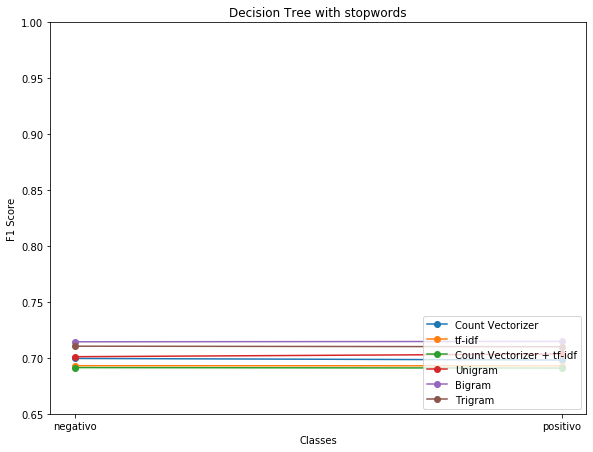

In [238]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Decision Tree with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_01,marker="o",label='Count Vectorizer')
ax.plot(experiment_02,marker="o",label='tf-idf')
ax.plot(experiment_03,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_04,marker="o",label='Unigram')
ax.plot(experiment_05,marker="o",label='Bigram')
ax.plot(experiment_06,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [239]:
experiment_01_sw

array([0.70363975, 0.70640325])

In [240]:
experiment_02_sw

array([0.69783184, 0.6944115 ])

In [241]:
experiment_03_sw

array([0.70300222, 0.70091309])

In [242]:
experiment_04_sw

array([0.70489473, 0.70750856])

In [243]:
experiment_05_sw

array([0.71702549, 0.71513102])

In [244]:
experiment_06_sw

array([0.71816467, 0.71797465])

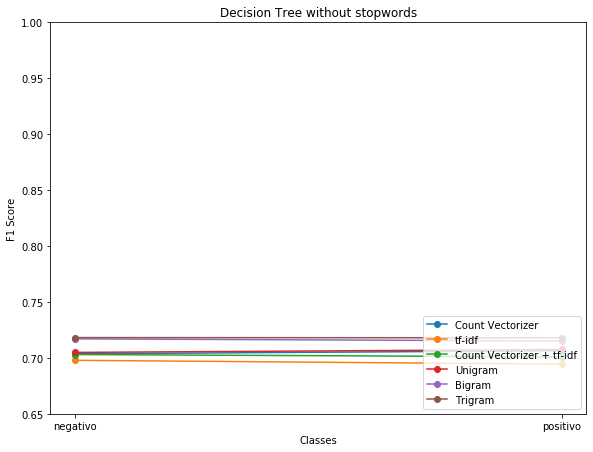

In [245]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Decision Tree without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_01_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_02_sw,marker="o",label='tf-idf')
ax.plot(experiment_03_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_04_sw,marker="o",label='Unigram')
ax.plot(experiment_05_sw,marker="o",label='Bigram')
ax.plot(experiment_06_sw,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

### Experimentos com Naive Bayes

In [246]:
experiment_11

array([0.84988635, 0.84281329])

In [247]:
experiment_12

array([0.86002473, 0.84965402])

In [248]:
experiment_13

array([0.85267685, 0.83718785])

In [249]:
experiment_14

array([0.84988635, 0.84281329])

In [250]:
experiment_15

array([0.87466352, 0.86782524])

In [251]:
experiment_16

array([0.88209864, 0.87506073])

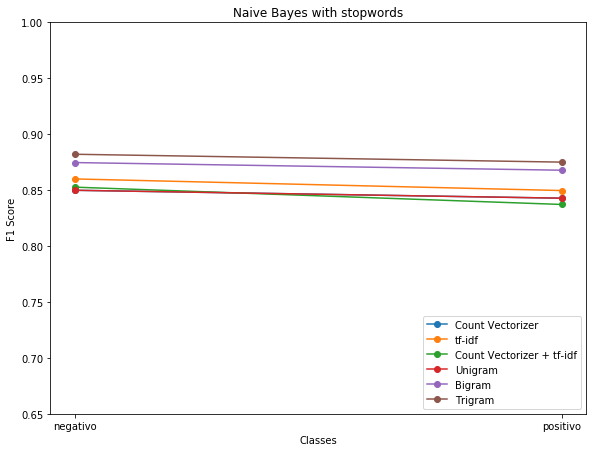

In [252]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Naive Bayes with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_11,marker="o",label='Count Vectorizer')
ax.plot(experiment_12,marker="o",label='tf-idf')
ax.plot(experiment_13,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_14,marker="o",label='Unigram')
ax.plot(experiment_15,marker="o",label='Bigram')
ax.plot(experiment_16,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [253]:
experiment_11_sw

array([0.85654555, 0.85201794])

In [254]:
experiment_12_sw

array([0.8612865 , 0.85425017])

In [255]:
experiment_13_sw

array([0.86243871, 0.8536755 ])

In [256]:
experiment_14_sw

array([0.85654555, 0.85201794])

In [257]:
experiment_15_sw

array([0.87750041, 0.87269354])

In [258]:
experiment_16_sw

array([0.87993122, 0.87525338])

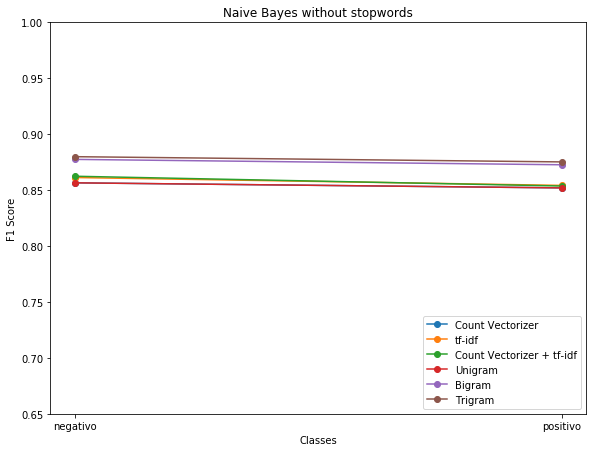

In [259]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Naive Bayes without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_11_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_12_sw,marker="o",label='tf-idf')
ax.plot(experiment_13_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_14_sw,marker="o",label='Unigram')
ax.plot(experiment_15_sw,marker="o",label='Bigram')
ax.plot(experiment_16_sw,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

### Experimentos com SVM/SVC

In [260]:
experiment_21

array([0.85286179, 0.86036125])

In [261]:
experiment_22

array([0.8832212 , 0.88741064])

In [262]:
experiment_23

array([0.86693659, 0.87160641])

In [263]:
experiment_24

array([0.85286179, 0.86036125])

In [264]:
experiment_25

array([0.86129831, 0.86670632])

In [265]:
experiment_26

array([0.85948334, 0.86186848])

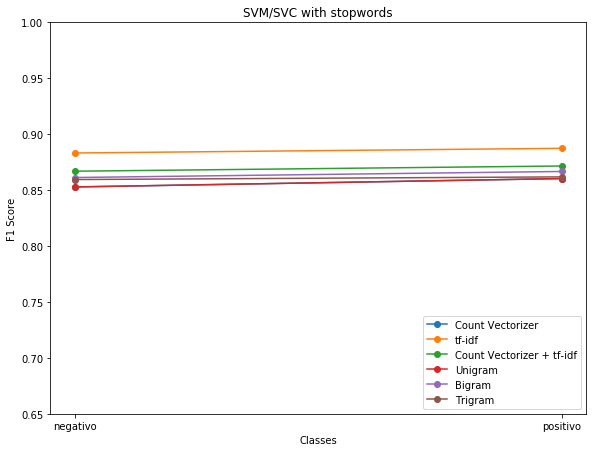

In [266]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('SVM/SVC with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_21,marker="o",label='Count Vectorizer')
ax.plot(experiment_22,marker="o",label='tf-idf')
ax.plot(experiment_23,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_24,marker="o",label='Unigram')
ax.plot(experiment_25,marker="o",label='Bigram')
ax.plot(experiment_26,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [267]:
experiment_21_sw

array([0.86234073, 0.87019152])

In [268]:
experiment_22_sw

array([0.88049536, 0.88526323])

In [269]:
experiment_23_sw

array([0.87173838, 0.87702159])

In [270]:
experiment_24_sw

array([0.86234073, 0.87019152])

In [271]:
experiment_25_sw

array([0.86612012, 0.87074019])

In [272]:
experiment_26_sw

array([0.86348042, 0.86562573])

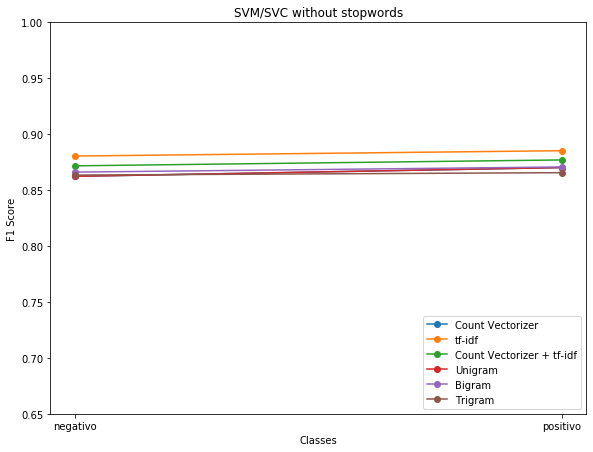

In [273]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('SVM/SVC without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['negativo', 'positivo'])
ax.set_xticks([0, 1])
ax.set_ylim([0.65,1])
ax.plot(experiment_21_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_22_sw,marker="o",label='tf-idf')
ax.plot(experiment_23_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_24_sw,marker="o",label='Unigram')
ax.plot(experiment_25_sw,marker="o",label='Bigram')
ax.plot(experiment_26_sw,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

## Análise dos resultados

A partir dos resultados obtidos pelos experimentos, os experimentos realizados com os modelo SVM/SVC e NB, com o pré-processamento do *dataset* utilizando `TF-IDF Vectorizer`, foram os que obtiveram melhores resultados (a partir da métrica F1 Score). Entretanto, não houve ganhos significativos com a remoção das *stopwords* em língua portuguesa &mdash; houve ganhos, já que a métrica F1 Score apresentou melhor resultado, mas não foram estatisticamente significantes, em geral.